In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# --- Aesthetic improvements ---
sns.set(style="whitegrid")
color_palette = sns.color_palette("husl", 8)  # Using a visually appealing color palette
sns.set_palette(color_palette)

# --- Load Data ---
try:
    preprocessed_classifier_data = pd.read_parquet('output/preprocessed_classifier_data.parquet')
    preprocessed_classifier_data = preprocessed_classifier_data.assign(result=lambda x: x['result'].apply(lambda y: y[0]))
    classifier_data = pd.read_parquet('output/classifier_data.parquet')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Ensure that 'output/preprocessed_classifier_data.parquet' and 'output/classifier_data.parquet' exist.")
except Exception as e:
    print(f"An error occurred while loading  {e}")


Data loaded successfully!


### Коэффициент принятия предложений

В этом разделе визуализируется коэффициент принятия предложений, показывающий процент принятых и отклоненных предложений. Данные получены из `preprocessed_classifier_data`.

/tmp/ipykernel_29564/3897775493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=acceptance_rate.index, y=acceptance_rate.values, palette=color_palette[:2])


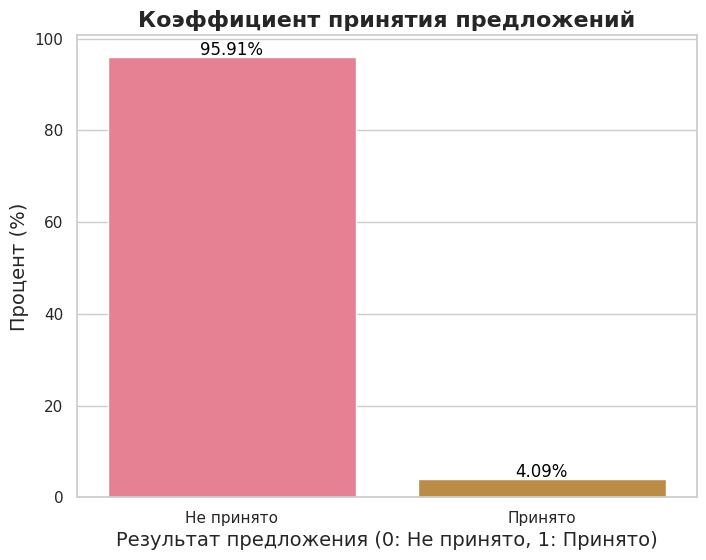

In [13]:
# --- Offer Acceptance Rate ---
if 'preprocessed_classifier_data' in locals():
    acceptance_rate = preprocessed_classifier_data['result'].value_counts(normalize=True) * 100

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=acceptance_rate.index, y=acceptance_rate.values, palette=color_palette[:2])
    plt.title('Коэффициент принятия предложений', fontsize=16, fontweight='bold')
    plt.xlabel('Результат предложения (0: Не принято, 1: Принято)', fontsize=14)
    plt.ylabel('Процент (%)', fontsize=14)
    plt.xticks([0, 1], ['Не принято', 'Принято'])

    # Adding value annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.show()
else:
    print("preprocessed_classifier_data not loaded. Skipping Offer Acceptance Rate plot.")

### Анализ разницы во времени

В этом разделе анализируются различия во времени между последовательными событиями. Вычисляется время, прошедшее между каждым действием, и визуализируется распределение этих временных различий. Данные получены из `preprocessed_classifier_data`.

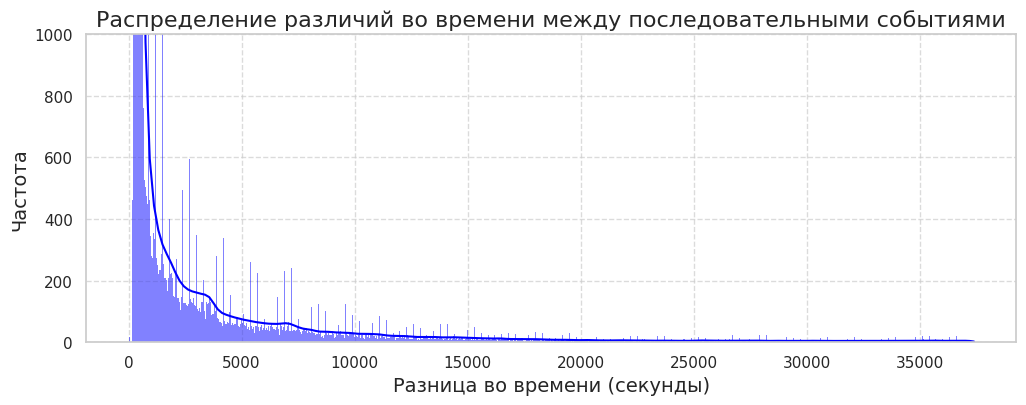

Mean time difference: 2987.75 seconds
Standard deviation of time differences: 17196.44 seconds


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if 'preprocessed_classifier_data' in locals():
    df = preprocessed_classifier_data.sample(10000)
    time_diffs = []
    for guid, group in df.groupby('offer_date'):
        event_times = group['event_time'].iloc[0]
        if len(event_times) > 1:
            diffs = np.diff(event_times)
            time_diffs.extend(diffs)

    time_diffs = np.array(time_diffs)
    mean = np.mean(time_diffs)
    std = np.std(time_diffs)
    typical_values = time_diffs[(time_diffs >= mean - 2*std) & (time_diffs <= mean + 2*std)]

    plt.figure(figsize=(12, 4))
    sns.histplot(typical_values, bins=5000, kde=True, color='blue')
    plt.ylim(0, 1000)
    plt.xlabel('Разница во времени (секунды)', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.title('Распределение различий во времени между последовательными событиями', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"Mean time difference: {mean:.2f} seconds")
    print(f"Standard deviation of time differences: {std:.2f} seconds")
else:
    print("preprocessed_classifier_data not loaded. Skipping Time Difference Analysis.")

### Распределение количества действий

В этом разделе визуализируется распределение количества действий. Он показывает, сколько действий обычно связано с каждым предложением. Обратите внимание, что для `classifier_data` мы рассматриваем только неделю до предложения.

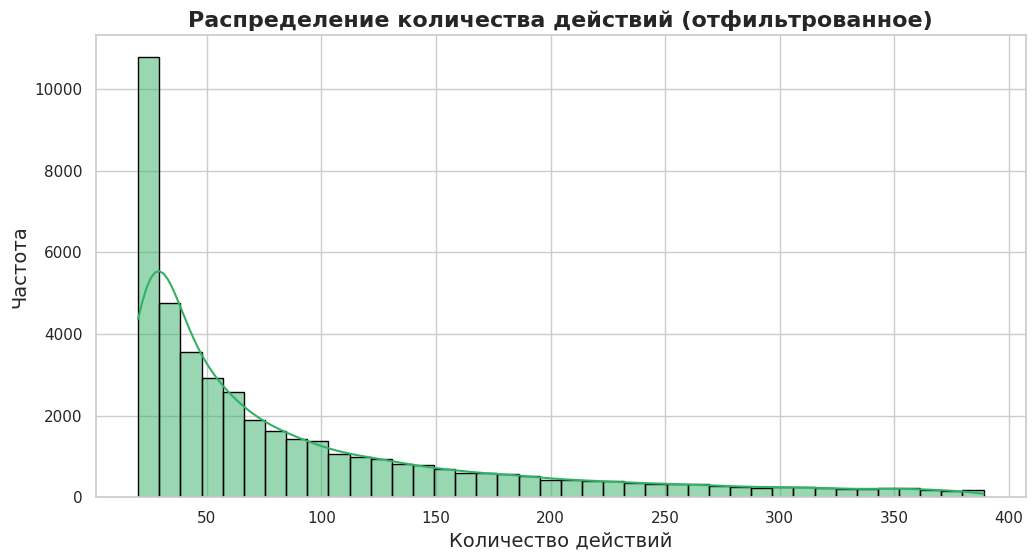

Action Counts Summary Statistics:
count    44238.000000
mean        92.305235
std         85.251124
min         20.000000
25%         30.000000
50%         57.000000
75%        124.000000
max        389.000000
Name: action, dtype: float64


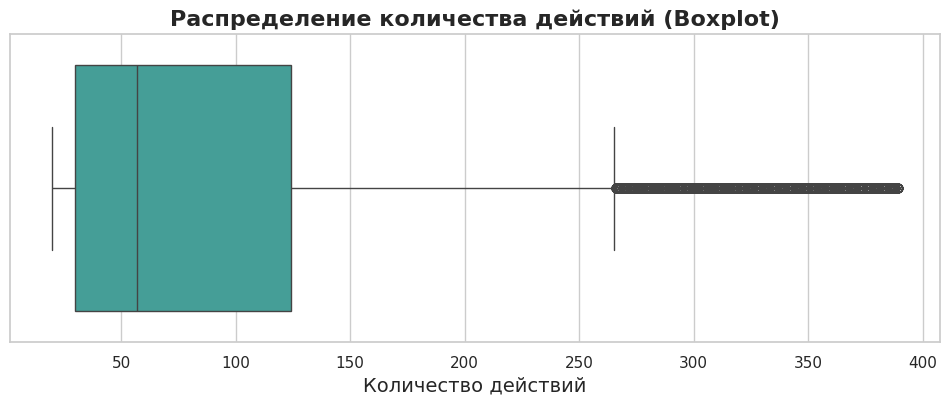

In [16]:
# --- Action Count Distribution ---
if 'classifier_data' in locals():
    action_counts = classifier_data.groupby('offer_date')['action'].count().reset_index()
    action_counts_filtered = action_counts[action_counts['action'] <= action_counts['action'].quantile(0.9)]

    plt.figure(figsize=(12, 6))
    sns.histplot(action_counts_filtered['action'], bins=40, kde=True, color=color_palette[3], edgecolor='black')
    plt.title('Распределение количества действий (отфильтрованное)', fontsize=16, fontweight='bold')
    plt.xlabel('Количество действий', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

    print("Action Counts Summary Statistics:")
    print(action_counts_filtered['action'].describe())

    plt.figure(figsize=(12, 4))
    sns.boxplot(x=action_counts_filtered['action'], color=color_palette[4])
    plt.title('Распределение количества действий (Boxplot)', fontsize=16, fontweight='bold')
    plt.xlabel('Количество действий', fontsize=14)
    plt.show()
else:
    print("classifier_data not loaded. Skipping Action Count Distribution plot.")

### Распределение действий во времени

В этом разделе визуализируется, как количество действий изменяется во времени. Это помогает выявить тенденции или закономерности в поведении пользователей, связанные с предложениями. Обратите внимание, что для `classifier_data` мы рассматриваем только неделю до предложения.

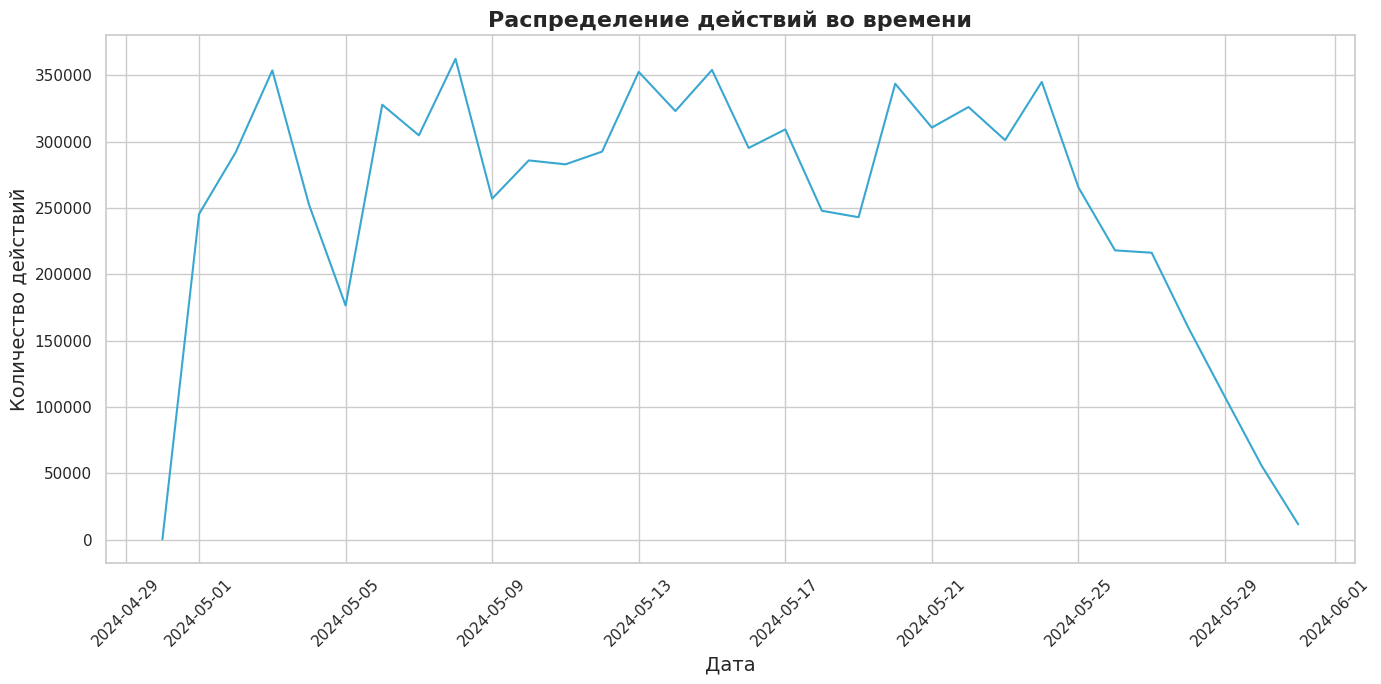

In [17]:
# --- Action Distribution Over Time ---
if 'classifier_data' in locals():
    # Ensure 'action_date' is in datetime format
    classifier_data['action_date'] = pd.to_datetime(classifier_data['action_date'])

    # Group by date and count the number of actions
    actions_over_time = classifier_data.groupby(classifier_data['action_date'].dt.date)['action'].count()

    # Plotting the time series
    plt.figure(figsize=(14, 7))
    actions_over_time.plot(kind='line', color=color_palette[5])
    plt.title('Распределение действий во времени', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Количество действий', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("classifier_data not loaded. Skipping Action Distribution Over Time plot.")